In [29]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import sqlite3
from pathlib import Path
from Core.data_access import DAO, CS
%matplotlib widget


with open("Runs/DEModel_V2-Base-attack/algorithm_a_PP_WindOn_New_c_PP_PV_New_20.pkl", "rb") as f:
    algorithm_data = pickle.load(f)
# with open("Runs/DEModel-attack-50/input_output.pkl", "rb") as f:
#     input_output_attack = pickle.load(f)
db_path = Path(".").joinpath("Runs", "DEModel_V2-Base", "padm.sqlite")
conn = sqlite3.connect(db_path)
dao = DAO(conn)

attacked_cs = CS("PP_WindOn_New","Dummy","Electricity")
constrained_cs = CS("PP_PV_New","Dummy","Electricity")

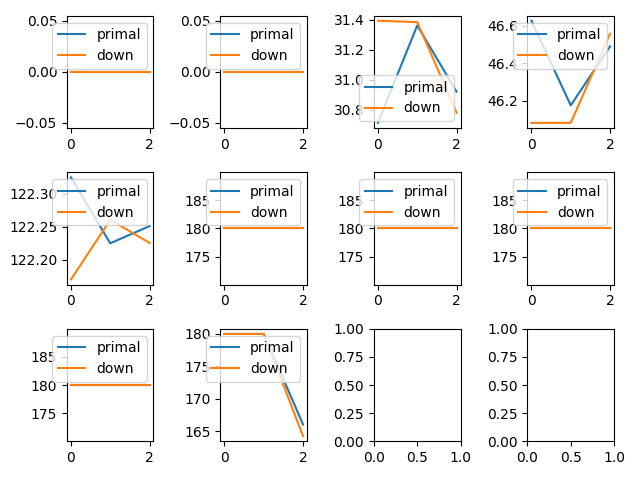

In [36]:
fig, ax = plt.subplots(3, 4)
ax = ax.flatten()
for i,year in enumerate(dao.get_set("year")):
    up = [cap["primal"].get(year,0) for cap in algorithm_data["cap_active"]]
    down = [cap["dual"].get(year,0) for cap in algorithm_data["cap_active"]]
    # ax[i].set_title(f"{y_int}")
    ax[i].plot(up, label="primal")
    ax[i].plot(down, label="down")
    ax[i].legend()
fig.tight_layout()
plt.show()

In [40]:
Wind_avail = [dao.get_row("availability_profile", attacked_cs,t) for t in dao.get_set("time")]
PV_avail = [dao.get_row("availability_profile", constrained_cs,t) for t in dao.get_set("time")]
wind_avail_manipulated = []
for i,t in enumerate(dao.get_set("time")):
    wind_avail_manipulated.append(Wind_avail[i] * (1 + dao.get_row("upper",t)))

# demand_values = [input.param.availability.output_profile[Demand_Electricity,t]*50 for t in input.dataset.times]

ValueError: Upper is not neither input parameter nor output variable

NameError: name 'Wind_avail' is not defined

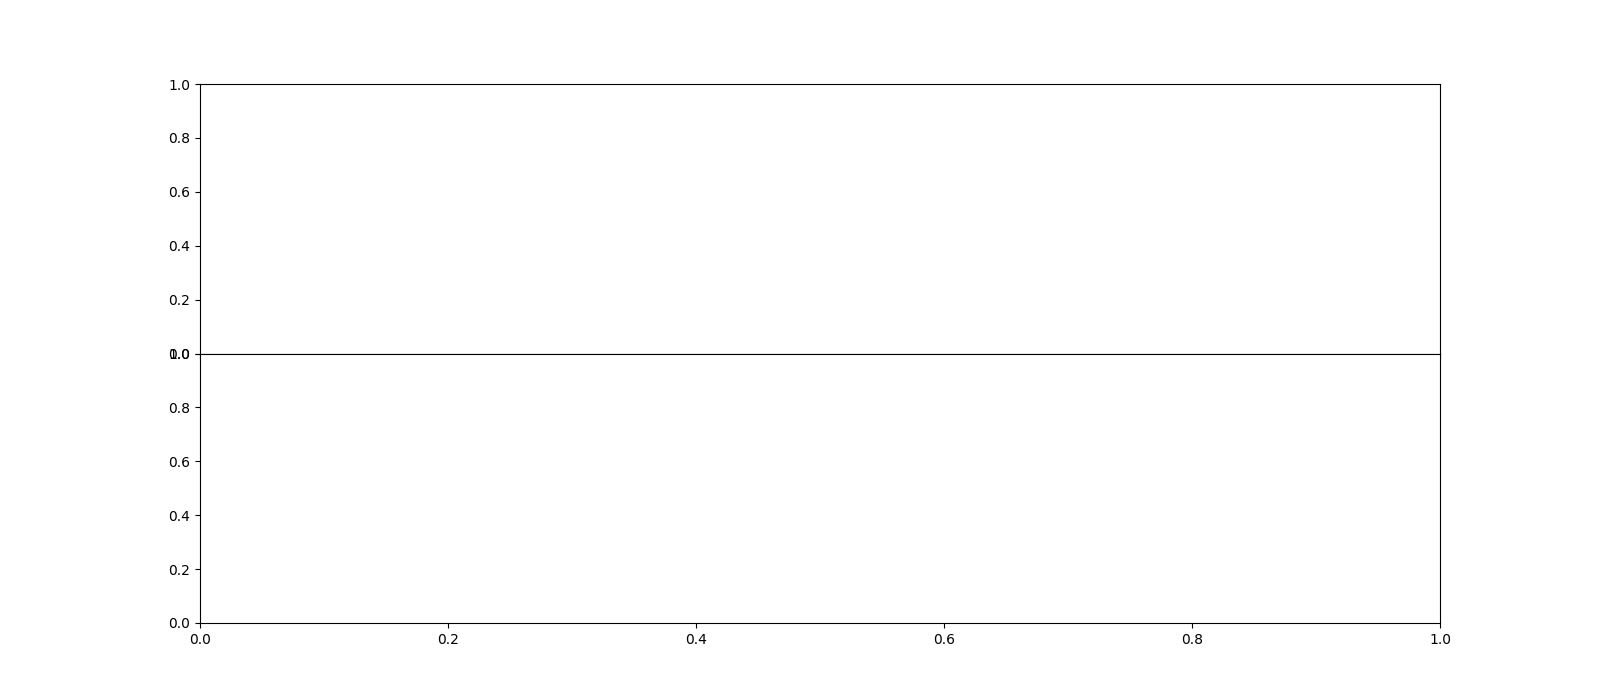

In [37]:
fig = plt.figure(figsize=(16,7))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
axs[0].plot(Wind_avail, label="Manipulated wind availability", linestyle='dashed')
axs[0].plot(wind_avail_manipulated, label="Original wind availability")
axs[0].legend(loc='upper left')
indices = [0, 55, 111, 167,223]
axs[0].set_xticks( indices, [i+1 for i in indices])
axs[0].set_yticks(np.arange(0, 1.1, step=0.2))
axs[0].set_ylim((-0.1,1.1))
axs[0].set_ylabel("Wind availability")
# plt.plot(demand_values, label="demand")

# for i in range(4):
#     plt.plot(range(0+i*56,(i+1)*56), PV_avail_values[0+i*56:(i+1)*56], label = "PV_avail", alpha = .2)
axs[1].plot(PV_avail, label = "PV availability")#, alpha = .2)
axs[1].legend(loc='upper left')
axs[1].set_ylabel("PV availability")
axs[1].set_xlabel("Time steps")
plt.show()

# print(np.corrcoef(Wind_avail_values, PV_avail_values))
# print(np.corrcoef(Wind_avail_attack_values, PV_avail_values))
# print(np.corrcoef(Wind_avail_values, demand_values))
# print(np.corrcoef(Wind_avail_attack_values, demand_values))

[(ConversionProcess(_value='PP_PV_New'),Commodity(_value='Dummy'),Commodity(_value='Electricity')), (ConversionProcess(_value='PP_WindOff_New'),Commodity(_value='Dummy'),Commodity(_value='Electricity')), (ConversionProcess(_value='PP_Gas'),Commodity(_value='Gas'),Commodity(_value='Electricity')), (ConversionProcess(_value='Central_Heat_Pump'),Commodity(_value='Electricity'),Commodity(_value='Industrial_Heat_LT')), (ConversionProcess(_value='Furnace_Gas'),Commodity(_value='Gas'),Commodity(_value='Industrial_Heat_HT')), (ConversionProcess(_value='Central_Biomass_Boiler'),Commodity(_value='Biomass'),Commodity(_value='Industrial_Heat_LT')), (ConversionProcess(_value='Gas_CHP'),Commodity(_value='Help_Gas_CHP'),Commodity(_value='Electricity')), (ConversionProcess(_value='PP_Coal'),Commodity(_value='Coal'),Commodity(_value='Electricity')), (ConversionProcess(_value='Import_Biomass'),Commodity(_value='Dummy'),Commodity(_value='Biomass')), (ConversionProcess(_value='Gas_CHP'),Commodity(_value='

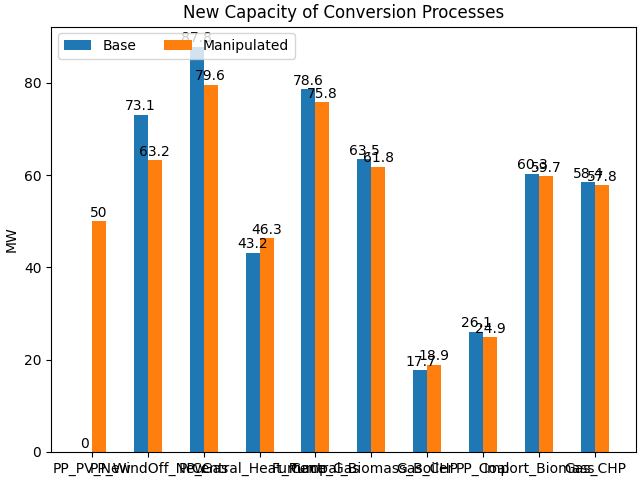

In [128]:
# data from https://allisonhorst.github.io/palmerpenguins/

cap_new = {"original":{}, "manipulated":{}}
for cs in input.dataset.conversion_subprocesses:
    # if cs.cout != Electricity:
    #     continue
    cap_original = 0
    cap_manipulated = 0
    for y in input.dataset.years:
        cap_original += input_output["output"].power.Cap_new[cs,y]
        cap_manipulated += input_output_attack["output"].power.Cap_new[cs,y]
    cap_new["original"][cs] = cap_original
    cap_new["manipulated"][cs] = cap_manipulated

diff_dict = {cs : abs(cap_new["original"][cs] - cap_new["manipulated"][cs]) for cs in cap_new["manipulated"]}
diff_dict = dict(sorted(diff_dict.items(), key=lambda item: item[1], reverse=True))

NUM = 10
keys = [key for key in diff_dict][:NUM]
new_capacities = {
    'Base': [cap_new["original"][key] for key in keys],
    'Manipulated': [cap_new["manipulated"][key] for key in keys],
}
print(keys)
cp = [str(key.cp) for key in keys]

x = np.arange(len(cp))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in new_capacities.items():
    measurement = [round(value,1) for value in measurement]
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=1)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MW')
ax.set_title('New Capacity of Conversion Processes')
ax.set_xticks(x + width/2, cp)
ax.legend(loc='upper left', ncols=2)
# ax.set_ylim(0, 250)

plt.show()

[876099.3946430896, 876099.3946430896] [875985.2509315594, 876104.2212353084]


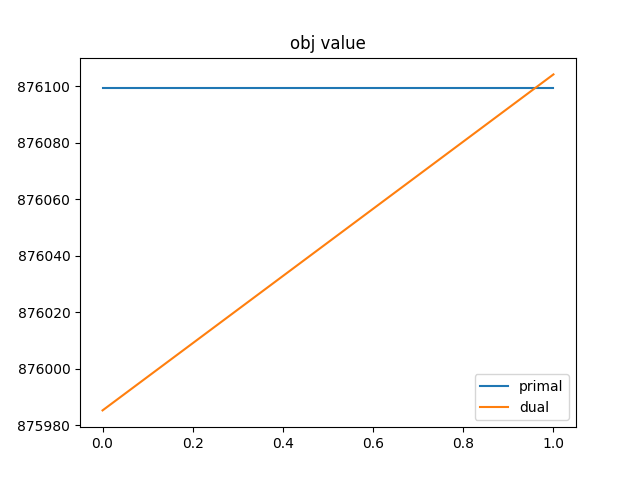

In [6]:
primal = [data["primal"] for data in algorithm_data["obj"]]
dual = [data["dual"] for data in algorithm_data["obj"]]
print(primal,dual)
plt.figure()
plt.plot(primal, label="primal")
plt.plot(dual, label="dual")
plt.legend()
plt.title("obj value")
plt.show()